In [ ]:
#ASTRO ZETER
#Deep Space Detectives
'''
ABHINAV V R
BENEETA JUSTICE
SREEPADH

'''

'\nABHINAV V R\nBENEETA JUSTICE\nSOBHIDAS\nSREEHARI\nKASIM AFRAZ\n\n'

In [2]:

!pip install -q lightkurve astroquery pandas numpy astropy tensorflow scikit-learn matplotlib requests tqdm
# lightkurve and astroquery are the core tools for fetching MAST / TESS / Kepler data.

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 116.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatibl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# if you want to store downloaded CSVs / arrays / models:
import os
DRIVE_PATH = "/content/drive/MyDrive/exoplanet_ml"
os.makedirs(DRIVE_PATH, exist_ok=True)
print("Will save to:", DRIVE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Will save to: /content/drive/MyDrive/exoplanet_ml


In [3]:
import os, io, time, math, requests
from urllib.parse import quote_plus
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# astropy, lightkurve and TF
import astropy
from astropy import units as u
from astropy.time import Time

import lightkurve as lk
from lightkurve import search_lightcurvefile

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, classification_report

/usr/local/lib/python3.12/dist-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [4]:
base = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"

def download_table(table_name, out_csv):
    q = f"select * from {table_name}"
    url = f"{base}?query={quote_plus(q)}&format=csv"
    print("Downloading:", url)
    r = requests.get(url, timeout=120)
    r.raise_for_status()
    with open(out_csv, "wb") as f:
        f.write(r.content)
    print("Saved", out_csv, "size:", os.path.getsize(out_csv))

# files will be saved to current working directory (or change path to DRIVE_PATH)
download_table("toi", "TOI_table.csv")
download_table("cumulative", "KOI_cumulative.csv")

# load them
toi = pd.read_csv("TOI_table.csv", low_memory=False)
koi = pd.read_csv("KOI_cumulative.csv", low_memory=False)

print("TOI rows:", len(toi), "KOI rows:", len(koi))
print("TOI columns sample:", list(toi.columns)[:30])
print("KOI columns sample:", list(koi.columns)[:30])

Downloading: https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+%2A+from+toi&format=csv
Saved TOI_table.csv size: 4763253
Downloading: https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+%2A+from+cumulative&format=csv
Saved KOI_cumulative.csv size: 11843766
TOI rows: 7703 KOI rows: 9564
TOI columns sample: ['tid', 'toi', 'toidisplay', 'toipfx', 'ctoi_alias', 'pl_pnum', 'tfopwg_disp', 'st_tmag', 'st_tmagerr1', 'st_tmagerr2', 'st_tmagsymerr', 'st_tmaglim', 'rastr', 'ra', 'raerr1', 'raerr2', 'rasymerr', 'decstr', 'dec', 'decerr1', 'decerr2', 'decsymerr', 'st_pmra', 'st_pmraerr1', 'st_pmraerr2', 'st_pmrasymerr', 'st_pmralim', 'st_pmdec', 'st_pmdecerr1', 'st_pmdecerr2']
KOI columns sample: ['kepid', 'kepoi_name', 'kepler_name', 'ra', 'ra_err', 'ra_str', 'dec', 'dec_err', 'dec_str', 'koi_gmag', 'koi_gmag_err', 'koi_rmag', 'koi_rmag_err', 'koi_imag', 'koi_imag_err', 'koi_zmag', 'koi_zmag_err', 'koi_jmag', 'koi_jmag_err', 'koi_hmag', 'koi_hmag_err', 'koi_kmag', 'koi_km

In [ ]:
# Count dispositions in TOI
print("TOI dispositions counts:")
print(toi['tfopwg_disp'].value_counts(dropna=False).head(20))

# Count KOI dispositions
print("KOI dispositions counts (sample):")
print(koi['koi_disposition'].value_counts(dropna=False).head(20))

# Build a small sample from TOI (TESS) for quick runs
# Keep only rows where we have TIC (tid), period (pl_orbper) and transit midpoint (pl_tranmid)
toi_good = toi.dropna(subset=['tid', 'pl_orbper', 'pl_tranmid', 'tfopwg_disp'])
# Map dispositions to binary labels: PC or CP -> label=1 (planet/candidate), FP/FA -> 0
pos_mask = toi_good['tfopwg_disp'].isin(['PC','CP','KP']) # KP = Known Planet
neg_mask = toi_good['tfopwg_disp'].isin(['FP','FA'])
pos = toi_good[pos_mask]
neg = toi_good[neg_mask]

print("Available TOI pos:", len(pos), "neg:", len(neg))

# sample up to N examples each class (for fast prototype)
N_each = 25
sample_pos = pos.sample(min(N_each, len(pos)), random_state=42)
sample_neg = neg.sample(min(N_each, len(neg)), random_state=42)
sample_df = pd.concat([sample_pos, sample_neg]).reset_index(drop=True)
print("Sample dataset size:", len(sample_df))
sample_df[['toi','tid','pl_orbper','pl_tranmid','pl_trandurh','tfopwg_disp']].head()

TOI dispositions counts:
tfopwg_disp
PC     4679
FP     1197
CP      684
KP      583
APC     462
FA       98
Name: count, dtype: int64
KOI dispositions counts (sample):
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64
Available TOI pos: 5858 neg: 1280
Sample dataset size: 50


toi        tid  pl_orbper    pl_tranmid  pl_trandurh tfopwg_disp
0   756.01   73649615   1.239257  2.458571e+06     1.086045          PC
1  5114.01   26693519   6.153908  2.460281e+06     2.115000          PC
2  3231.01  280857321   2.173826  2.460043e+06     2.081000          PC
3  1074.01  327301957  13.942870  2.458663e+06     3.752276          PC
4  5204.01   65845738   1.593603  2.459825e+06     3.244000          PC

In [ ]:
def fetch_tess_lc_by_tic(tic_id, mission='TESS', max_downloads=3):
    """
    Returns a stitched LightCurve (PDCSAP or SAP) or None if unavailable.
    tic_id: integer or string
    """
    q = f"TIC {int(tic_id)}"
    try:
        sr = search_lightcurvefile(q, mission=mission)
        if len(sr) == 0:
            return None
        # try to download all (multiple sectors) and stitch
        lcf_all = sr.download_all()
        # lcf_all might be a LightCurveFileCollection; attempt to stitch PDCSAP first
        try:
            lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
        except Exception:
            try:
                lc = lcf_all.SAP_FLUX.stitch().remove_nans()
            except Exception:
                # fallback: download first file only
                lcf = sr.download()
                if hasattr(lcf, 'PDCSAP_FLUX'):
                    lc = lcf.PDCSAP_FLUX.remove_nans()
                else:
                    lc = lcf.SAP_FLUX.remove_nans()
        return lc
    except Exception as e:
        # network / MAST errors occasionally happen
        print("fetch_tess_lc error for", tic_id, ":", str(e))
        return None

# quick test on first sample TIC
test_tic = int(sample_df.iloc[0]['tid'])
print("Testing fetch for TIC:", test_tic)
lc_test = fetch_tess_lc_by_tic(test_tic)
print("Got LC:", type(lc_test), "length:", None if lc_test is None else len(lc_test))

Testing fetch for TIC: 73649615


/tmp/ipython-input-3321482343.py:8: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(q, mission=mission)
/tmp/ipython-input-3321482343.py:15: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/tmp/ipython-input-3321482343.py:18: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.SAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:171: LightkurveDeprecationWarning: The SAP_FLUX function is 

Got LC: <class 'lightkurve.lightcurve.TessLightCurve'> length: 14909


/tmp/ipython-input-3321482343.py:22: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  if hasattr(lcf, 'PDCSAP_FLUX'):
/tmp/ipython-input-3321482343.py:23: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans()


local shape (101,) global shape (201,)


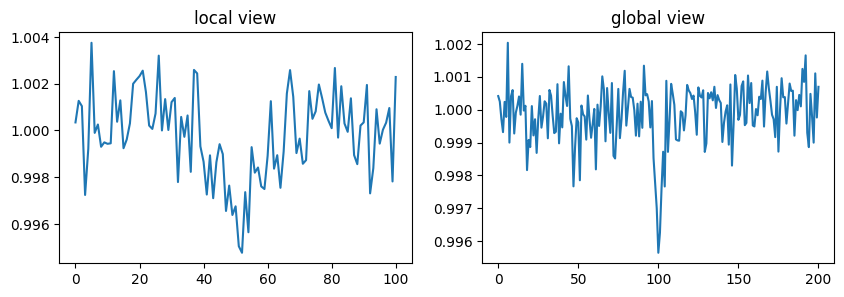

In [ ]:
def fold_and_bin(lc, period_days, t0_bjd, dur_hours=None, n_local=101, n_global=201, local_dur_mult=2.0):
    """
    lc: lightkurve LightCurve with lc.time.value in BTJD (TESS) or BKJD (Kepler) units
    period_days: orbital period (days)
    t0_bjd: mid-transit time (BJD) --> convert to mission timebase outside
    dur_hours: transit duration in hours (optional, used to set local window)
    returns: local_array (n_local,), global_array (n_global,)
    """
    # Convert t0_bjd to mission timebase: for TESS lightcurves times are BTJD = BJD - 2457000
    # We assume the caller has already done conversion to LC timescale.
    # lc.time.value is in days.
    time = lc.time.value   # e.g., BTJD for TESS
    flux = lc.flux.value
    # remove NaNs
    mask = np.isfinite(time) & np.isfinite(flux)
    time = time[mask]
    flux = flux[mask]

    # Compute phase (centered on t0): phase in days in range [-period/2, period/2)
    phase = ((time - 0.5 * period_days - (t0_bjd)) % period_days) - 0.5 * period_days
    # Note: here t0_bjd must be in the same timebase as time (i.e., already converted).
    # For local window size:
    if dur_hours is not None and dur_hours > 0:
        dur_days = dur_hours / 24.0
    else:
        # fallback: small fraction of period
        dur_days = max(0.05 * period_days, 0.05)  # at least 0.05 day

    local_window = local_dur_mult * dur_days

    # Helper to bin an array across [-win, +win]
    def bin_view(ph, fl, win, nbins):
        left = -win
        right = win
        bins = np.linspace(left, right, nbins + 1)
        inds = np.digitize(ph, bins) - 1
        binned = np.full(nbins, np.nan)
        for i in range(nbins):
            sel = (inds == i)
            if sel.any():
                binned[i] = np.mean(fl[sel])
        # fill missing with median (or 1.0 if normalized)
        med = np.nanmedian(binned)
        if np.isnan(med):
            med = 1.0
        binned = np.where(np.isfinite(binned), binned, med)
        return binned

    global_view = bin_view(phase, flux, period_days / 2.0, n_global)
    local_view  = bin_view(phase, flux, local_window, n_local)

    # normalize by median
    if np.nanmedian(global_view) != 0:
        global_view = global_view / np.nanmedian(global_view)
    if np.nanmedian(local_view) != 0:
        local_view = local_view / np.nanmedian(local_view)

    return local_view.astype(np.float32), global_view.astype(np.float32)

# quick example (if lc_test exists and sample row has pl_orbper, pl_tranmid)
if lc_test is not None:
    row = sample_df.iloc[0]
    # convert TOI pl_tranmid (BJD) to BTJD for TESS lc: BTJD = BJD - 2457000
    t0_btjd = row['pl_tranmid'] - 2457000.0
    local, globalv = fold_and_bin(lc_test, float(row['pl_orbper']), t0_btjd, dur_hours=float(row.get('pl_trandurh', np.nan)), n_local=101, n_global=201)
    print("local shape", local.shape, "global shape", globalv.shape)
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1); plt.plot(local); plt.title("local view")
    plt.subplot(1,2,2); plt.plot(globalv); plt.title("global view")
    plt.show()

In [ ]:
out_dir = "./toi_sample_data"
os.makedirs(out_dir, exist_ok=True)

n_local = 101
n_global = 201

X_local = []
X_global = []
y = []
meta = []

for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    tic = int(row['tid'])
    disp = row['tfopwg_disp']
    # fetch LC
    lc = fetch_tess_lc_by_tic(tic)
    if lc is None:
        print("No LC for TIC", tic)
        continue
    # convert pl_tranmid BJD -> BTJD
    try:
        t0_btjd = float(row['pl_tranmid']) - 2457000.0
        period = float(row['pl_orbper'])
        dur_hours = float(row['pl_trandurh']) if not np.isnan(row.get('pl_trandurh', np.nan)) else None
    except Exception as e:
        print("Missing ephemeris for row", idx, "skip:", e)
        continue
    local_view, global_view = fold_and_bin(lc, period, t0_btjd, dur_hours, n_local=n_local, n_global=n_global)
    X_local.append(local_view.reshape(n_local,1))
    X_global.append(global_view.reshape(n_global,1))
    label = 1 if disp in ['PC','CP','KP'] else 0
    y.append(label)
    meta.append({'toi': row['toi'], 'tid': tic, 'tfopwg_disp': disp, 'period': period})

X_local = np.array(X_local)
X_global = np.array(X_global)
y = np.array(y)
meta_df = pd.DataFrame(meta)

print("Built dataset shapes:", X_local.shape, X_global.shape, y.shape)
np.savez_compressed(os.path.join(out_dir,"toi_sample.npz"), X_local=X_local, X_global=X_global, y=y)
meta_df.to_csv(os.path.join(out_dir,"meta.csv"), index=False)
print("Saved to", out_dir)

  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipython-input-3321482343.py:8: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(q, mission=mission)
/tmp/ipython-input-3321482343.py:15: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/tmp/ipython-input-3321482343.py:18: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.SAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:171: LightkurveDeprecationWarning: The SAP_FLUX function is 

fetch_tess_lc error for 116242971 : Not recognized as a supported data product:
/root/.lightkurve/cache/mastDownload/HLSP/hlsp_diamante_tess_lightcurve_tic-0000000116242971_tess_v2_llc/hlsp_diamante_tess_lightcurve_tic-0000000116242971_tess_v2_llc.fits
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
No LC for TIC 116242971


/tmp/ipython-input-3321482343.py:8: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(q, mission=mission)
/tmp/ipython-input-3321482343.py:15: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/tmp/ipython-input-3321482343.py:18: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.SAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:171: LightkurveDeprecationWarning: The SAP_FLUX function is 

fetch_tess_lc error for 220076110 : Not recognized as a supported data product:
/root/.lightkurve/cache/mastDownload/HLSP/hlsp_diamante_tess_lightcurve_tic-0000000220076110_tess_v1_llc/hlsp_diamante_tess_lightcurve_tic-0000000220076110_tess_v1_llc.fits
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
No LC for TIC 220076110


/tmp/ipython-input-3321482343.py:8: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(q, mission=mission)
/tmp/ipython-input-3321482343.py:15: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/tmp/ipython-input-3321482343.py:18: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.SAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:171: LightkurveDeprecationWarning: The SAP_FLUX function is 

fetch_tess_lc error for 258920431 : Not recognized as a supported data product:
/root/.lightkurve/cache/mastDownload/HLSP/hlsp_diamante_tess_lightcurve_tic-0000000258920431_tess_v2_llc/hlsp_diamante_tess_lightcurve_tic-0000000258920431_tess_v2_llc.fits
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
No LC for TIC 258920431


/tmp/ipython-input-3321482343.py:8: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(q, mission=mission)
/tmp/ipython-input-3321482343.py:15: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/tmp/ipython-input-3321482343.py:18: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.SAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:171: LightkurveDeprecationWarning: The SAP_FLUX function is 

fetch_tess_lc error for 199289712 : 'pdcsap_flux'
No LC for TIC 199289712


fetch_tess_lc error for 349576261 : Not recognized as a supported data product:
/root/.lightkurve/cache/mastDownload/HLSP/hlsp_t16_tess_ffi_s0005-cam4-ccd4-05288681857665822080_tess_v01/hlsp_t16_tess_ffi_s0005-cam4-ccd4-05288681857665822080_tess_v01_llc.fits
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
No LC for TIC 349576261


/tmp/ipython-input-3321482343.py:8: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(q, mission=mission)
/tmp/ipython-input-3321482343.py:15: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/tmp/ipython-input-3321482343.py:18: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.SAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:171: LightkurveDeprecationWarning: The SAP_FLUX function is 

fetch_tess_lc error for 294395926 : Not recognized as a supported data product:
/root/.lightkurve/cache/mastDownload/HLSP/hlsp_t16_tess_ffi_s0003-cam4-ccd4-05490097505810081024_tess_v01/hlsp_t16_tess_ffi_s0003-cam4-ccd4-05490097505810081024_tess_v01_llc.fits
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
No LC for TIC 294395926


/tmp/ipython-input-3321482343.py:8: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(q, mission=mission)
/tmp/ipython-input-3321482343.py:15: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/tmp/ipython-input-3321482343.py:18: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.SAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:171: LightkurveDeprecationWarning: The SAP_FLUX function is 

fetch_tess_lc error for 131036011 : 'pdcsap_flux'
No LC for TIC 131036011


/tmp/ipython-input-3321482343.py:15: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/tmp/ipython-input-3321482343.py:18: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.SAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:171: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.SAP_FLUX for lc in self])
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 4 files available to download. Only the 

fetch_tess_lc error for 268372005 : 'pdcsap_flux'
No LC for TIC 268372005


/tmp/ipython-input-3321482343.py:15: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/tmp/ipython-input-3321482343.py:18: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.SAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:171: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.SAP_FLUX for lc in self])
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 6 files available to download. Only the 

fetch_tess_lc error for 23650642 : Not recognized as a supported data product:
/root/.lightkurve/cache/mastDownload/HLSP/hlsp_diamante_tess_lightcurve_tic-0000000023650642_tess_v2_llc/hlsp_diamante_tess_lightcurve_tic-0000000023650642_tess_v2_llc.fits
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
No LC for TIC 23650642


/tmp/ipython-input-3321482343.py:8: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(q, mission=mission)
/tmp/ipython-input-3321482343.py:15: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/tmp/ipython-input-3321482343.py:18: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.SAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:171: LightkurveDeprecationWarning: The SAP_FLUX function is 

fetch_tess_lc error for 282498590 : Not recognized as a supported data product:
/root/.lightkurve/cache/mastDownload/HLSP/hlsp_diamante_tess_lightcurve_tic-0000000282498590_tess_v1_llc/hlsp_diamante_tess_lightcurve_tic-0000000282498590_tess_v1_llc.fits
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
No LC for TIC 282498590


/tmp/ipython-input-3321482343.py:8: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = search_lightcurvefile(q, mission=mission)
/tmp/ipython-input-3321482343.py:15: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/tmp/ipython-input-3321482343.py:18: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.SAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:171: LightkurveDeprecationWarning: The SAP_FLUX function is 

fetch_tess_lc error for 90919952 : 'pdcsap_flux'
No LC for TIC 90919952


TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.')
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.')
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.')
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.')
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.')
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.')
TypeError('The value must be a valid Pyt

fetch_tess_lc error for 2041563029 : 'pdcsap_flux'
No LC for TIC 2041563029


/tmp/ipython-input-3321482343.py:15: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/tmp/ipython-input-3321482343.py:18: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.SAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:171: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.SAP_FLUX for lc in self])
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 7 files available to download. Only the 

Built dataset shapes: (38, 101, 1) (38, 201, 1) (38,)
Saved to ./toi_sample_data


/tmp/ipython-input-3321482343.py:22: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  if hasattr(lcf, 'PDCSAP_FLUX'):
/tmp/ipython-input-3321482343.py:23: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans()


In [ ]:
# load saved (or use X_local, X_global, y if still in memory)
data = np.load(os.path.join(out_dir,"toi_sample.npz"))
X_local = data['X_local']
X_global = data['X_global']
y = data['y']

# shapes
n_local = X_local.shape[1]
n_global = X_global.shape[1]

# Model builder
def build_astronet_two_branch(n_local=101, n_global=201):
    in_local = layers.Input(shape=(n_local,1), name='local')
    x1 = layers.Conv1D(16, kernel_size=5, activation='relu', padding='same')(in_local)
    x1 = layers.MaxPool1D(2)(x1)
    x1 = layers.Conv1D(32, 5, activation='relu', padding='same')(x1)
    x1 = layers.GlobalAveragePooling1D()(x1)

    in_global = layers.Input(shape=(n_global,1), name='global')
    x2 = layers.Conv1D(16, 11, activation='relu', padding='same')(in_global)
    x2 = layers.MaxPool1D(2)(x2)
    x2 = layers.Conv1D(32, 5, activation='relu', padding='same')(x2)
    x2 = layers.GlobalAveragePooling1D()(x2)

    x = layers.Concatenate()([x1, x2])
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model([in_local, in_global], out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

model = build_astronet_two_branch(n_local, n_global)
model.summary()

# Train (small epochs for prototype). Use class weights if imbalanced.
from sklearn.model_selection import train_test_split
Xl_train, Xl_val, Xg_train, Xg_val, y_train, y_val = train_test_split(X_local, X_global, y, test_size=0.2, random_state=42, stratify=y)
model_dir = "./models"
os.makedirs(model_dir, exist_ok=True)

cb = [
    callbacks.ModelCheckpoint(os.path.join(model_dir,"best.h5"), save_best_only=True, monitor='val_auc', mode='max'),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True)
]

# class weights
from sklearn.utils import class_weight
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(cw))
print("class_weight:", class_weight_dict)

history = model.fit([Xl_train, Xg_train], y_train,
                    validation_data=([Xl_val, Xg_val], y_val),
                    epochs=30, batch_size=16, callbacks=cb, class_weight=class_weight_dict)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ local (InputLayer)  │ (None, 101, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global (InputLayer) │ (None, 201, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 101, 16)   │         96 │ local[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 201, 16)   │        192 │ global[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 50, 16)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 100, 16)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 50, 32)    │      2,592 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 100, 32)   │      2,592 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv1d_3[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,697 (37.88 KB)

 Trainable params: 9,697 (37.88 KB)

 Non-trainable params: 0 (0.00 B)

class_weight: {0: np.float64(1.0), 1: np.float64(1.0)}
Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - auc: 0.4375 - loss: 0.7110

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - auc: 0.4250 - loss: 0.7122 - val_auc: 0.5000 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - auc: 0.4595 - loss: 0.6987 - val_auc: 0.5000 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - auc: 0.4459 - loss: 0.7011 - val_auc: 0.5000 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - auc: 0.4626 - loss: 0.7014 - val_auc: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - auc: 0.6537 - loss: 0.6797 - val_auc: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - auc: 0.3966 - loss: 0.7056 - val_auc: 0.5000 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - auc: 0.5731 - loss: 0.6877 - val_auc: 0.5000 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
PR AUC: 0.4202380952380952 ROC AUC: 0.4375


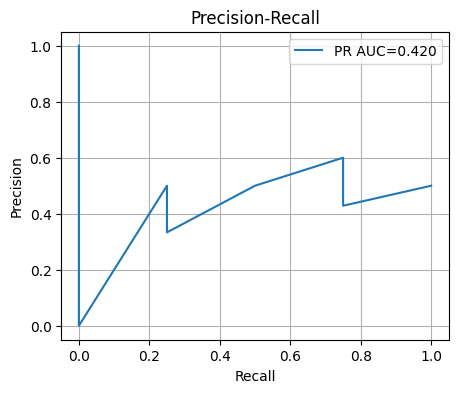

chosen threshold: 0.48200884
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      1.00      0.67         4

    accuracy                           0.50         8
   macro avg       0.25      0.50      0.33         8
weighted avg       0.25      0.50      0.33         8



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# predictions on validation
y_pred = model.predict([Xl_val, Xg_val]).ravel()
precision, recall, thresh = precision_recall_curve(y_val, y_pred)
pr_auc = auc(recall, precision)
roc = roc_auc_score(y_val, y_pred)
print("PR AUC:", pr_auc, "ROC AUC:", roc)
plt.figure(figsize=(5,4))
plt.plot(recall, precision, label=f"PR AUC={pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall")
plt.legend(); plt.grid(True)
plt.show()

# simple thresholded classification report
best_idx = np.argmax(precision * recall)  # heuristic; tune threshold for desired precision/recall
best_thresh = thresh[best_idx] if len(thresh)>0 else 0.5
print("chosen threshold:", best_thresh)
from sklearn.metrics import classification_report
print(classification_report(y_val, (y_pred >= best_thresh).astype(int)))

In [ ]:
# --------------------------

In [5]:
# Inspect first few rows
print("TESS Objects of Interest (TOI):")
display(toi.head())

print("\nKepler Objects of Interest (KOI Cumulative):")
display(koi.head())

# Check column names
print("\nTOI Columns:")
print(toi.columns.tolist())

print("\nKOI Columns:")
print(koi.columns.tolist())

TESS Objects of Interest (TOI):


tid      toi   toidisplay  toipfx    ctoi_alias  pl_pnum tfopwg_disp  \
0   16288184  1049.01  TOI-1049.01    1049  1.628818e+07        1          KP   
1  144065872   105.01   TOI-105.01     105  1.440659e+08        1          KP   
2   66818296  1050.01  TOI-1050.01    1050  6.681830e+07        1          KP   
3  259863352  1051.01  TOI-1051.01    1051  2.598634e+08        1          FA   
4  317060587  1052.01  TOI-1052.01    1052  3.170606e+08        1          CP   

   st_tmag  st_tmagerr1  st_tmagerr2  ...  st_logglim   st_rad st_raderr1  \
0  11.0657        0.006       -0.006  ...           0  1.27146   0.063558   
1   9.4995        0.006       -0.006  ...           0  1.23824   0.059699   
2  11.0261        0.006       -0.006  ...           0  1.57000   0.090000   
3   7.1278        0.006       -0.006  ...           0  1.56486   0.186629   
4   9.0197        0.006       -0.006  ...           0  1.58000   0.165123   

   st_raderr2  st_radsymerr  st_radlim  sectors          toi_created  \
0   -0.063558             1          0      NaN  2019-07-15 19:20:04   
1   -0.059699             1          0      NaN  2018-09-05 18:49:20   
2   -0.090000             1          0      NaN  2019-07-15 19:20:05   
3   -0.186629             1          0      NaN  2019-08-16 20:20:45   
4   -0.165123             1          0      NaN  2019-08-16 20:20:47   

             rowupdate         release_date  
0  2022-03-30 16:02:02  2025-09-28 22:48:44  
1  2025-03-25 16:00:01  2025-09-28 22:48:44  
2  2022-10-05 10:10:01  2025-09-28 22:48:44  
3  2024-09-17 10:08:02  2025-09-28 22:48:44  
4  2023-07-24 12:03:31  2025-09-28 22:48:44  

[5 rows x 91 columns]


Kepler Objects of Interest (KOI Cumulative):


kepid kepoi_name   kepler_name         ra  ra_err        ra_str  \
0  10797460  K00752.01  Kepler-227 b  291.93423     0.0  19h27m44.22s   
1  10797460  K00752.02  Kepler-227 c  291.93423     0.0  19h27m44.22s   
2  10811496  K00753.01           NaN  297.00482     0.0  19h48m01.16s   
3  10848459  K00754.01           NaN  285.53461     0.0  19h02m08.31s   
4  10854555  K00755.01  Kepler-664 b  288.75488     0.0  19h15m01.17s   

         dec  dec_err       dec_str  koi_gmag  ...  koi_fpflag_co  \
0  48.141651      0.0  +48d08m29.9s    15.890  ...              0   
1  48.141651      0.0  +48d08m29.9s    15.890  ...              0   
2  48.134129      0.0  +48d08m02.9s    15.943  ...              0   
3  48.285210      0.0  +48d17m06.8s    16.100  ...              0   
4  48.226200      0.0  +48d13m34.3s    16.015  ...              0   

   koi_fpflag_ec  koi_insol  koi_insol_err1  koi_insol_err2  koi_srho  \
0              0      93.59           29.45          -16.65   3.20796   
1              0       9.11            2.87           -1.62   3.02368   
2              0      39.30           31.04          -10.49   7.29555   
3              0     891.96          668.95         -230.35   0.22080   
4              0     926.16          874.33         -314.24   1.98635   

   koi_srho_err1  koi_srho_err2  koi_fittype  koi_score  
0        0.33173       -1.09986      LS+MCMC      1.000  
1        2.20489       -2.49638      LS+MCMC      0.969  
2       35.03293       -2.75453      LS+MCMC      0.000  
3        0.00917       -0.01837      LS+MCMC      0.000  
4        2.71141       -1.74541      LS+MCMC      1.000  

[5 rows x 153 columns]


TOI Columns:
['tid', 'toi', 'toidisplay', 'toipfx', 'ctoi_alias', 'pl_pnum', 'tfopwg_disp', 'st_tmag', 'st_tmagerr1', 'st_tmagerr2', 'st_tmagsymerr', 'st_tmaglim', 'rastr', 'ra', 'raerr1', 'raerr2', 'rasymerr', 'decstr', 'dec', 'decerr1', 'decerr2', 'decsymerr', 'st_pmra', 'st_pmraerr1', 'st_pmraerr2', 'st_pmrasymerr', 'st_pmralim', 'st_pmdec', 'st_pmdecerr1', 'st_pmdecerr2', 'st_pmdecsymerr', 'st_pmdeclim', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_tranmidsymerr', 'pl_tranmidlim', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbpersymerr', 'pl_orbperlim', 'pl_trandurh', 'pl_trandurherr1', 'pl_trandurherr2', 'pl_trandurhsymerr', 'pl_trandurhlim', 'pl_trandep', 'pl_trandeperr1', 'pl_trandeperr2', 'pl_trandepsymerr', 'pl_trandeplim', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radesymerr', 'pl_radelim', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insolsymerr', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtsymerr', 'pl_eqtlim', 'st_dist', 'st_disterr1

In [6]:
# Choose relevant columns from KOI cumulative dataset
useful_cols = [
    'koi_period',       # Orbital period (days)
    'koi_duration',     # Transit duration (hours)
    'koi_depth',        # Transit depth (ppm)
    'koi_prad',         # Planetary radius (Earth radii)
    'koi_teq',          # Equilibrium temperature (K)
    'koi_srad',         # Stellar radius (solar radii)
    'koi_smass',        # Stellar mass (solar masses)
    'koi_steff',        # Stellar effective temperature
    'koi_disposition'   # Label: CONFIRMED / FALSE POSITIVE / CANDIDATE
]

df = koi[useful_cols].dropna()
df.head()

koi_period  koi_duration  koi_depth  koi_prad  koi_teq  koi_srad  \
0    9.488036       2.95750      615.8      2.26    793.0     0.927   
1   54.418383       4.50700      874.8      2.83    443.0     0.927   
2   19.899140       1.78220    10829.0     14.60    638.0     0.868   
3    1.736952       2.40641     8079.2     33.46   1395.0     0.791   
4    2.525592       1.65450      603.3      2.75   1406.0     1.046   

   koi_smass  koi_steff koi_disposition  
0      0.919     5455.0       CONFIRMED  
1      0.919     5455.0       CONFIRMED  
2      0.961     5853.0       CANDIDATE  
3      0.836     5805.0  FALSE POSITIVE  
4      1.095     6031.0       CONFIRMED

In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['koi_disposition'])
df.drop('koi_disposition', axis=1, inplace=True)

print("Encoded Labels:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))
df.head()

Encoded Labels: {'CANDIDATE': np.int64(0), 'CONFIRMED': np.int64(1), 'FALSE POSITIVE': np.int64(2)}


koi_period  koi_duration  koi_depth  koi_prad  koi_teq  koi_srad  \
0    9.488036       2.95750      615.8      2.26    793.0     0.927   
1   54.418383       4.50700      874.8      2.83    443.0     0.927   
2   19.899140       1.78220    10829.0     14.60    638.0     0.868   
3    1.736952       2.40641     8079.2     33.46   1395.0     0.791   
4    2.525592       1.65450      603.3      2.75   1406.0     1.046   

   koi_smass  koi_steff  label  
0      0.919     5455.0      1  
1      0.919     5455.0      1  
2      0.961     5853.0      0  
3      0.836     5805.0      2  
4      1.095     6031.0      1

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
model = RandomForestClassifier(n_estimators=200, random_state=42)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=encoder.classes_))

Accuracy: 0.7311243889190657

Classification Report:
                 precision    recall  f1-score   support

     CANDIDATE       0.52      0.39      0.44       405
     CONFIRMED       0.71      0.79      0.75       549
FALSE POSITIVE       0.81      0.85      0.83       887

      accuracy                           0.73      1841
     macro avg       0.68      0.68      0.67      1841
  weighted avg       0.72      0.73      0.72      1841



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
model = RandomForestClassifier(n_estimators=200, random_state=42)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=encoder.classes_))

Accuracy: 0.7311243889190657

Classification Report:
                 precision    recall  f1-score   support

     CANDIDATE       0.52      0.39      0.44       405
     CONFIRMED       0.71      0.79      0.75       549
FALSE POSITIVE       0.81      0.85      0.83       887

      accuracy                           0.73      1841
     macro avg       0.68      0.68      0.67      1841
  weighted avg       0.72      0.73      0.72      1841



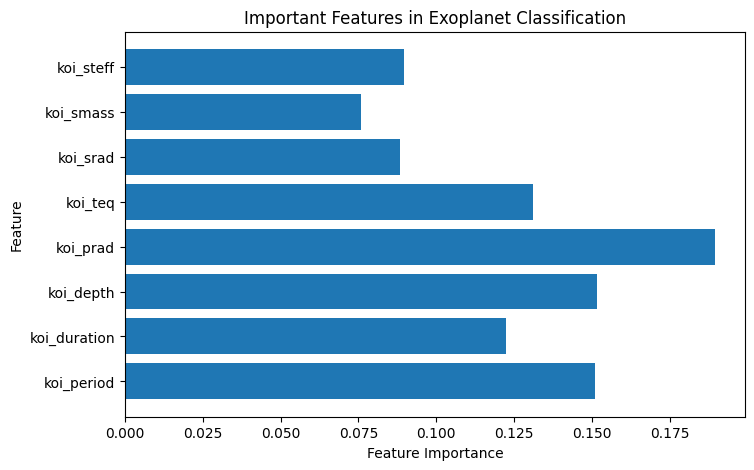

In [12]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = X.columns

plt.figure(figsize=(8,5))
plt.barh(indices, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Important Features in Exoplanet Classification")
plt.show()

In [13]:
import joblib

joblib.dump(model, "exoplanet_classifier.pkl")
print("✅ Model saved as exoplanet_classifier.pkl")

✅ Model saved as exoplanet_classifier.pkl


In [14]:
model = joblib.load("exoplanet_classifier.pkl")

In [15]:
!pip install lightkurve astroquery tensorflow numpy matplotlib

In [16]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [17]:
# Example: Download Kepler-10b (a known exoplanet)
search_result = lk.search_lightcurvefile('Kepler-10', mission='Kepler')
search_result

# Download the first available file
lc_file = search_result.download()

/tmp/ipython-input-2877016314.py:2: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  search_result = lk.search_lightcurvefile('Kepler-10', mission='Kepler')
/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 50 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


/tmp/ipython-input-3918937852.py:1: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lc_file.PDCSAP_FLUX.remove_nans()


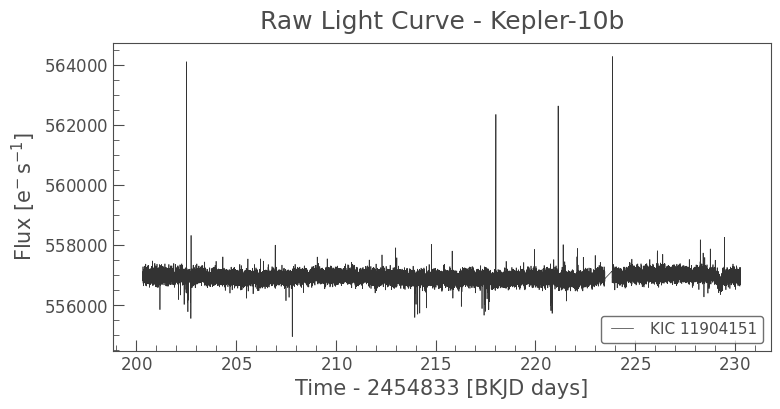

In [18]:
lc = lc_file.PDCSAP_FLUX.remove_nans()
lc.plot(title="Raw Light Curve - Kepler-10b")
plt.show()

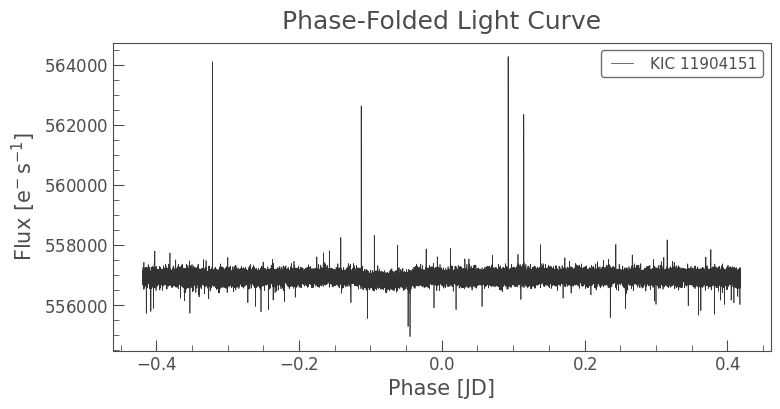

In [19]:
period = 0.837495  # example: Kepler-10b orbital period (days)

# Phase-fold the light curve around the period
folded_lc = lc.fold(period=period)
folded_lc.plot(title="Phase-Folded Light Curve")
plt.show()

In [20]:
# Get normalized flux and phase values
flux = folded_lc.flux.value
time = folded_lc.phase.value

# Normalize flux
flux = (flux - np.min(flux)) / (np.max(flux) - np.min(flux))

# Reshape for CNN (samples, timesteps, features)
X = flux.reshape(1, -1, 1)
y = np.array([1])  # label 1 for confirmed planet (for demo)

In [21]:
model = Sequential([
    Conv1D(16, 5, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(32, 5, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 43357, 16)      │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 21678, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 21674, 32)      │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10837, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 346784)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    22,194,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,196,993 (84.67 MB)

 Trainable params: 22,196,993 (84.67 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.fit(X, y, epochs=10, batch_size=1)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.6223
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 3.7299e-11
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 6.4308e-25
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 1.0128e-17
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 3.7871e-39
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0000e+00


In [23]:
# Example prediction
prediction = model.predict(X)
print("Predicted probability of exoplanet:", prediction[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
Predicted probability of exoplanet: 1.0


In [24]:
import lightkurve as lk
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [35]:
def preprocess_lightcurve(kepid, period):
    try:
        # Search for Kepler light curve
        result = lk.search_lightcurvefile(f'KIC {kepid}', mission='Kepler')
        if len(result) == 0:
            return None

        # Download all available files and stitch
        lcf_all = result.download_all()

        # Try PDCSAP_FLUX first, then SAP_FLUX
        try:
            lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
        except Exception:
            try:
                lc = lcf_all.SAP_FLUX.stitch().remove_nans()
            except Exception:
                # Fallback to downloading the first file and trying both fluxes
                lcf = result.download()
                if hasattr(lcf, 'PDCSAP_FLUX'):
                    lc = lcf.PDCSAP_FLUX.remove_nans()
                elif hasattr(lcf, 'SAP_FLUX'):
                    lc = lcf.SAP_FLUX.remove_nans()
                else:
                    return None


        folded_lc = lc.fold(period=period)

        flux = folded_lc.flux.value
        # phase = folded_lc.phase.value # Phase is not used for CNN input

        # Normalize flux
        flux = (flux - np.min(flux)) / (np.max(flux) - np.min(flux))
        flux = flux.reshape(-1, 1)

        return flux
    except Exception as e:
        print(f"Error for KIC {kepid}: {e}")
        return None

In [26]:
confirmed = koi[koi['koi_disposition'] == 'CONFIRMED'].sample(5, random_state=42)
false_pos = koi[koi['koi_disposition'] == 'FALSE POSITIVE'].sample(5, random_state=42)

dataset = pd.concat([confirmed, false_pos])
dataset = dataset[['kepid', 'koi_period', 'koi_disposition']].dropna()
dataset.head()

kepid  koi_period koi_disposition
1918   6768394    8.919012       CONFIRMED
3987  11444514   66.373298       CONFIRMED
2818   9527334    8.313773       CONFIRMED
2546  11963206    3.009125       CONFIRMED
5873   4947556   13.026796       CONFIRMED

In [37]:
X_data, y_data = [], []

for _, row in tqdm(dataset.iterrows(), total=len(dataset)):
    lc_flux = preprocess_lightcurve(int(row['kepid']), row['koi_period'])
    if lc_flux is not None and len(lc_flux) > 200:
        X_data.append(lc_flux[:200])  # keep same length (first 200 samples)
        y_data.append(1 if row['koi_disposition'] == 'CONFIRMED' else 0)

X = np.array(X_data)
y = np.array(y_data)

print("✅ Dataset prepared")
print("X shape:", X.shape)
print("y shape:", y.shape)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipython-input-325100816.py:4: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  result = lk.search_lightcurvefile(f'KIC {kepid}', mission='Kepler')
/tmp/ipython-input-325100816.py:13: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
 10%|█         | 1/10 [01:25<12:46, 85.22s/it]/tmp/ipython-input-325100816.py:4: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  result = lk.sear

✅ Dataset prepared
X shape: (10, 200, 1)
y shape: (10,)


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv1D(32, 5, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 196, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 98, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 94, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 47, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3008)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       385,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,777 (1.51 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(X, y, epochs=20, batch_size=2, validation_split=0.2, verbose=1)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.1833 - loss: 0.7374 - val_accuracy: 0.0000e+00 - val_loss: 0.7065
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6333 - loss: 0.6811 - val_accuracy: 0.0000e+00 - val_loss: 0.7352
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6500 - loss: 0.7015 - val_accuracy: 0.0000e+00 - val_loss: 0.7230
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 0.6979
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5500 - loss: 0.6822 - val_accuracy: 0.5000 - val_loss: 0.7333
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7333 - loss: 0.6444 - val_accuracy: 0.0000e+00 - val_loss: 0.8911
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7333 - loss: 0.6017 - val_accuracy: 0.0000e+00 - val_loss: 0.9169
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5833 - loss: 0.6458 - val_accuracy: 0.500

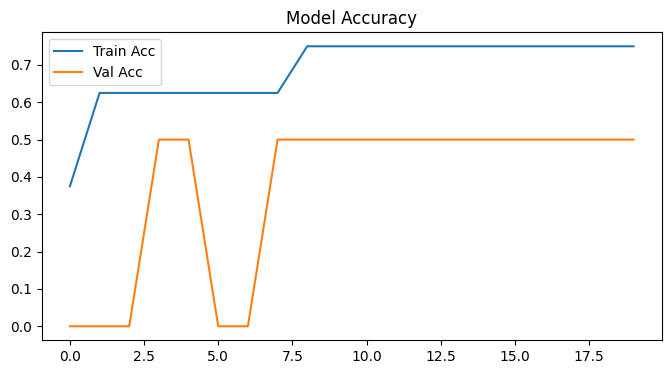

In [40]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.legend()
plt.show()

In [41]:
test_flux = preprocess_lightcurve(11446443, 2.3)  # Example: KIC 11446443
if test_flux is not None:
    test_flux = test_flux[:200].reshape(1, 200, 1)
    pred = model.predict(test_flux)
    print("Predicted probability of exoplanet:", pred[0][0])

/tmp/ipython-input-325100816.py:4: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  result = lk.search_lightcurvefile(f'KIC {kepid}', mission='Kepler')
/tmp/ipython-input-325100816.py:13: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
Predicted probability of exoplanet: 0.6553317


In [42]:

import joblib
model.save("kepler_exoplanet_cnn.h5")
print("✅ Model saved as kepler_exoplanet_cnn.h5")

✅ Model saved as kepler_exoplanet_cnn.h5


/tmp/ipython-input-325100816.py:4: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  result = lk.search_lightcurvefile(f'KIC {kepid}', mission='Kepler')
/tmp/ipython-input-325100816.py:13: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


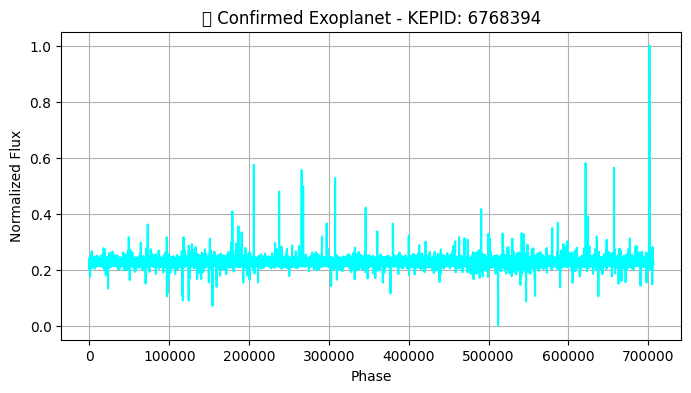

/tmp/ipython-input-325100816.py:4: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  result = lk.search_lightcurvefile(f'KIC {kepid}', mission='Kepler')
/tmp/ipython-input-325100816.py:13: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf_all.PDCSAP_FLUX.stitch().remove_nans()
/usr/local/lib/python3.12/dist-packages/lightkurve/collections.py:163: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


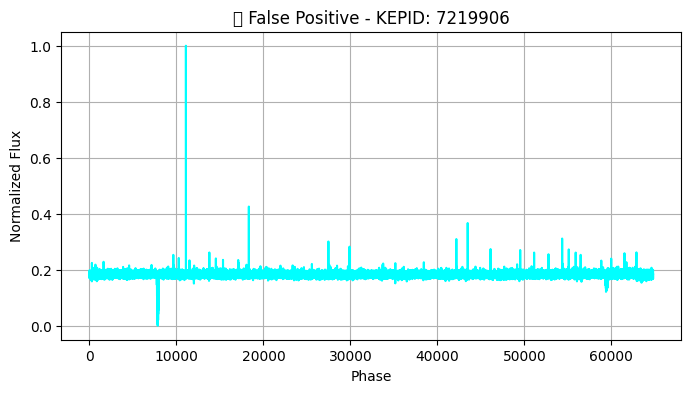

In [43]:
import matplotlib.pyplot as plt

def plot_example(kepid, period, label):
    lc = preprocess_lightcurve(kepid, period)
    if lc is not None:
        plt.figure(figsize=(8,4))
        plt.plot(lc, color='cyan')
        plt.title(f"{label} - KEPID: {kepid}")
        plt.xlabel("Phase")
        plt.ylabel("Normalized Flux")
        plt.grid(True)
        plt.show()

# Example: plot one confirmed and one false positive from dataset
confirmed_sample = dataset[dataset['koi_disposition']=='CONFIRMED'].iloc[0]
false_sample = dataset[dataset['koi_disposition']=='FALSE POSITIVE'].iloc[0]

plot_example(int(confirmed_sample['kepid']), confirmed_sample['koi_period'], "✅ Confirmed Exoplanet")
plot_example(int(false_sample['kepid']), false_sample['koi_period'], "🚫 False Positive")

In [44]:

predictions = model.predict(X).flatten()

results_df = pd.DataFrame({
    'kepid': dataset['kepid'].values[:len(predictions)],
    'True Label': y,
    'Predicted Prob.': predictions
})

results_df['Predicted Label'] = (results_df['Predicted Prob.'] > 0.5).astype(int)
results_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


kepid  True Label  Predicted Prob.  Predicted Label
0   6768394           1         0.699736                1
1  11444514           1         0.742565                1
2   9527334           1         0.766126                1
3  11963206           1         0.742879                1
4   4947556           1         0.954218                1

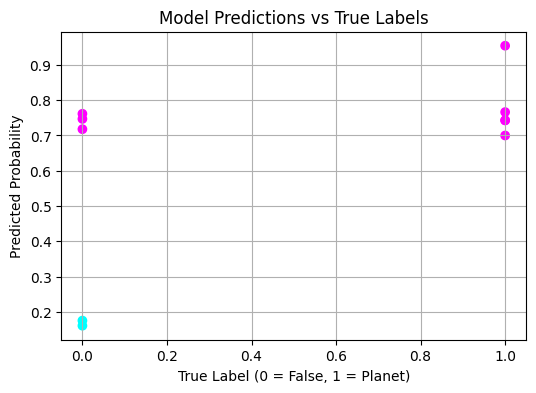

In [45]:
plt.figure(figsize=(6,4))
plt.scatter(results_df['True Label'], results_df['Predicted Prob.'], c=results_df['Predicted Label'], cmap='cool')
plt.title("Model Predictions vs True Labels")
plt.xlabel("True Label (0 = False, 1 = Planet)")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.show()

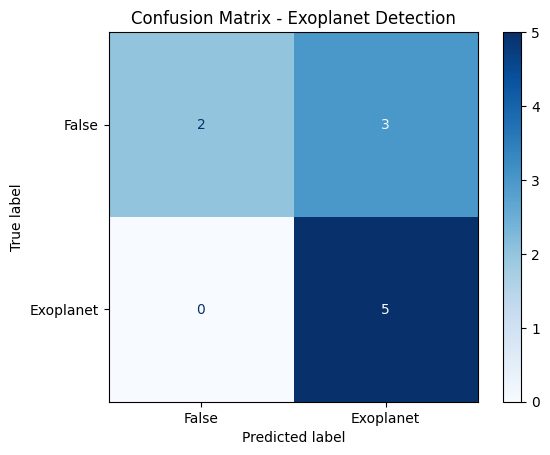

In [46]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(results_df['True Label'], results_df['Predicted Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False', 'Exoplanet'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Exoplanet Detection")
plt.show()

In [47]:
results_df.to_csv("exoplanet_predictions.csv", index=False)
print("✅ Results saved as exoplanet_predictions.csv")

✅ Results saved as exoplanet_predictions.csv
